# CIS 5200: Machine Learning
## Homework 1

In [1]:
import os
import sys

# For autograder only, do not modify this cell.
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Penngrader setup

In [2]:
# %%capture
!pip install penngrader-client

In [3]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [4]:
from penngrader.grader import PennGrader

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 17994725 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

grader = PennGrader('config.yaml', 'cis5200_sp25_HW1', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 17994725

Make sure this correct or we will not be able to store your grade


In [5]:
from dill.source import getsource

# 1. Perceptron

In this first problem, you will implement the perceptron algorithm. Since the algorithm requires linearly separate data and real data is usually noisy, we will have to use a synthetic example.

In [6]:
import torch

# Data generation for perceptron problem
torch.manual_seed(42)

m,d = 10,2
X_perceptron = torch.randn(m,d) # generate random data
w_opt = torch.randn(d) # generate random optimal solution
y_perceptron = torch.sign(X_perceptron.matmul(w_opt)) # generate solution-consistent labels

We've given you a template for the perceptron algorithm. Calculate the following remaining functions:

1. (3pts) Calculate the theoretical margin given the optimal linear classifier
2. (3pts) Compute the condition for when the perceptron algorithm makes an update on a specific example
3. (3pts) Compute the perceptron algorithm update to the weights when the update condition is satisfied

You do not need to change `perceptron_algorithm`.

In [7]:
def perceptron_margin(X, w_opt):
    # X := Tensor(float) of size (m,d) --- This is a batch of m examples of
    #     of dimension d
    #
    # w_opt := Tensor(float) of size (d,) --- This is the ground truth linear
    #     weights
    #
    # Return := Tensor(float) of size (1,) --- This is the theoretical margin
    #
    return torch.min(torch.abs(X.matmul(w_opt))/torch.norm(w_opt))
    raise NotImplementedError("TODO: Fill me in!")

def perceptron_update_condition(xi, yi, w):
    # xi := Tensor(float) of size (d,) --- This is a a single example of
    #     of dimension d
    #
    # yi := Tensor(float) of size (1,) --- This is a single label for the
    #     example xi
    #
    # w := Tensor(float) of size (d,) --- This is the current estimate of the
    #     linear weights
    #
    # Return := Tensor(bool) of size (1,) --- This is true if the perceptron
    #     algorithim will do an update on this example, and false otherwise
    #
    return torch.sign(xi.matmul(w)) != yi
    raise NotImplementedError("TODO: Fill me in!")

def perceptron_update_weight(xi, yi, w):
    # xi := Tensor(float) of size (d,) --- This is a a single example of
    #     of dimension d
    #
    # yi := Tensor(float) of size (1,) --- This is a single label for the
    #     example xi
    #
    # w := Tensor(float) of size (d,) --- This is the current estimate of the
    #     linear weights
    #
    # Return := Tensor(float) of size (d,) --- This is the updated linear
    #     weights after performing the perceptron update
    #
    return w + yi*xi
    raise NotImplementedError("TODO: Fill me in!")

def perceptron_algorithm(X, y, niters=100):
    m,d = X.size()
    w = torch.zeros(d)
    for t in range(niters):
        weight_updated = False
        for xi,yi in zip(X,y):
            if perceptron_update_condition(xi, yi, w):
                w = perceptron_update_weight(xi, yi, w)
                weight_updated = True
                continue
        if not weight_updated:
            return w,t

Try running the perceptron algorithm. Does it terminate in fewer steps than the theoretical bound? Is the final classifier close to the ground truth?

Accuracy: 1.00 in 1 rounds.
Margin: 0.14. The perceptron algorithm is guaranteed to terminate in 53.92 rounds.


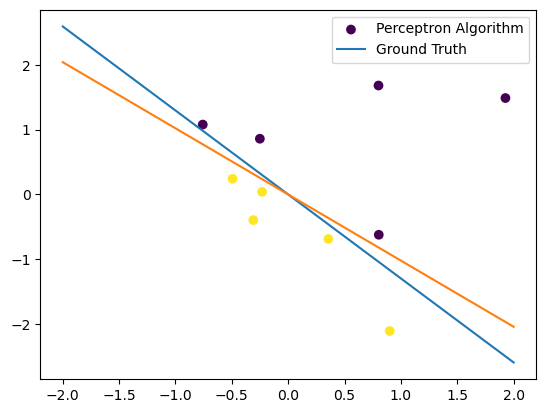

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Test this out on the synthetic data
w_perceptron,t = perceptron_algorithm(X_perceptron,y_perceptron)
acc_perceptron = (torch.sign(X_perceptron.matmul(w_perceptron)) == y_perceptron).float().mean()

print(f"Accuracy: {acc_perceptron:.2f} in {t} rounds.")

margin = perceptron_margin(X_perceptron,w_opt)
print(f"Margin: {margin:.2f}. The perceptron algorithm is guaranteed to terminate in {1/(margin**2):.2f} rounds.")

# Plot the classifier. Is it close to the the ground truth?
plt.scatter(X_perceptron[:,0], X_perceptron[:,1], c=y_perceptron)
X_range = torch.linspace(-2,2, 50)
plt.plot(X_range, -w_perceptron[0]/w_perceptron[1]*X_range) # estimated
plt.plot(X_range, -w_opt[0]/w_opt[1]*X_range) # optimal
plt.legend(['Perceptron Algorithm', 'Ground Truth'])
plt.show()

### Autograder
Check the following 3 test cases.

In [9]:
grader.grade(test_case_id = 'perceptron_margin', answer = getsource(perceptron_margin))
grader.grade(test_case_id = 'perceptron_update_condition', answer = getsource(perceptron_update_condition))
grader.grade(test_case_id = 'perceptron_update_weight', answer = getsource(perceptron_update_weight))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 2. k-Nearest Neighbors

In this problem, you'll implement the k nearest neighbors algorithm to solve a binary classification problem on handwritten digits.

# Dataset: MNIST

One of the earliest **big** successes of machine learning was in recognizing handwritten digits. This proved incredibly useful, for example, when automatically parsing zip codes from handwritten envelopes. Today, we'll load the MNIST database of handwritten digits and use it to solve a binary classification problem: predicting whether an image of a handwritten digit is of a $0$ or of an $8$.

In [10]:
import torchvision

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

train_x = mnist_train.data
train_y = mnist_train.targets

# MNIST contains digits of all different labels -- let's get just the 0 and 8 images.
train_x = train_x[torch.logical_or(train_y == 0, train_y == 8)]
train_y = train_y[torch.logical_or(train_y == 0, train_y == 8)]


# Load the MNIST test dataset
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_x = mnist_test.data
test_y = mnist_test.targets

# MNIST contains digits of all different labels -- let's get just the 0 and 8 images.
test_x = test_x[torch.logical_or(test_y == 0, test_y == 8)]
test_y = test_y[torch.logical_or(test_y == 0, test_y == 8)]

When we investigate the data a little bit, we find that we have a training set of 11774 images, each image is 28 x 28 and is greyscale. Let's print out the shape of `train_x`, and also plot some images using matplotlib

torch.Size([11774, 28, 28])


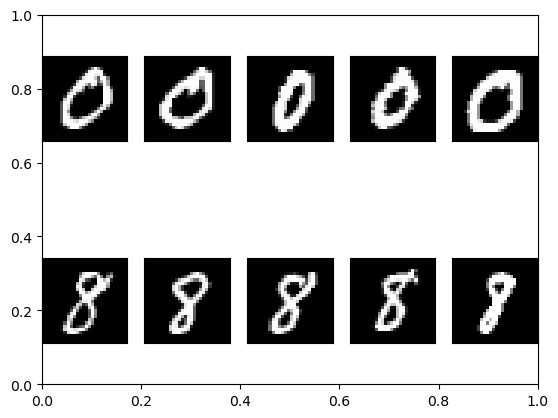

In [11]:
from matplotlib import pyplot as plt

print(train_x.shape)
fig, ax = plt.subplots()

# Plot 5 0's
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_x[train_y == 0][i], cmap='gray')
    plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False)

# Plot 5 8's.
for i in range(5, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_x[train_y == 8][i], cmap='gray')
    plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False)

plt.show()

Now, let's implement k Nearest Neighbors using simple Euclidean distance as our distance metric. We've given you a template for the actual algorithm, but you'll have to implement the guts of the algorithm yourself! Unfortunately, since
being able to program in PyTorch while effectively using broadcasting and other matrix operations is really important if you want to do machine learning, you'll need to implement the distance computation yourself without using `torch.cdist` or other similar
functions.

In [12]:
def knn_distance_matrix(test_x, train_x):
    """
    Given a set of testing and training data, compute a matrix of distances between all test points and all training points.

    Args:
        test_x (m x d tensor): Testing data that we want to make predictions for.
        train_x (n x d tensor): Training data that we'll use for making classifications.

    Returns:
        dist_mat (m x n tensor): a matrix D so that D_ij is the distance between the ith test point and the jth training point.

    Hints:
        - You may find it helpful to know that the **squared** Euclidean distance between two vectors x and z, ||x - z||^2, can be computed as (x - z)'(x - z) = x'x - 2*x'z + z'z.
          This formulation is much easier to implement using simple matrix multiplication, elementwise products, and broadcasting.
        - Implementing this function without for loops will be the trickiest part of implementing the algorithm.
    """
    test_x_squared = torch.sum(torch.pow(test_x, 2), dim=1).unsqueeze(1)
    train_x_squared = torch.sum(torch.pow(train_x, 2), dim=1).unsqueeze(0)
    test_train_x = torch.matmul(test_x, train_x.t())
    return torch.pow(test_x_squared - 2 * test_train_x + train_x_squared, 0.5)
    raise NotImplementedError("TODO: Fill me in!")

def knn_find_k_nearest_neighbors(D, k):
    """
    Given a distance matrix between test and train points, find the k nearest neighbors from the training points for each test point.

    Args:
        D (m x n tensor): a matrix D so that D_ij is the distance between the ith test point and jth training point (e.g., each *row* corresponds to a test point).
        k (int): How many nearest neighbors to find

    Returns:
        knn_inds (m x k tensor): For each test point, the indices of the k nearest neighbors in the training data. 
        In other words, if knn_inds[i, j] = q, then (train_x[q], train_y[q]) is one of the k nearest neighbors to test_x[q].

    Hints:
        - This time, you can get some help from real functions in PyTorch. In particular, you may find the torch.topk function useful (https://pytorch.org/docs/stable/generated/torch.topk.html).
        - This function can be implemented in as little as 1 (relatively short) line of code. If you find yourself struggling, you're probably not using torch.topk as well as you should.
    """
    return torch.topk(D, k, dim=1, largest=False).indices
    raise NotImplementedError("TODO: Fill me in!")

def knn_predict(train_y, knn_inds):
    """
    Given an m x k set of indices of nearest neighbors for each test point, use the training labels and these indices to make a final prediction for each test point.

    Args:
        train_y (n vector): Labels of the training data points
        knn_inds (m x k tensor): For each test point, the indices of the k nearest neighbors in the training data. In other words, if knn_inds[i, j] = q, then (train_x[q], train_y[q]) is one of the k nearest neighbors to test_x[q].

    Returns:
        predictions (m vector): A prediction of the label for each test point.

    Hints:
        - Suppose x is a vector with at least 6 entries and ix is a 2x3 matrix with entries [[0,2,4],[1,3,5]], then x[ix] will return a 2x3 matrix with entries [[x[0], x[2], x[4]],[x[1],x[3],x[5]]].
        - torch.mode (https://pytorch.org/docs/stable/generated/torch.mode.html) will be a pretty helpful function here.
    """
    return torch.mode(train_y[knn_inds], dim=1).values
    raise NotImplementedError("TODO: Fill me in!")

def knn_algorithm(test_x, train_x, train_y, k=3):
    """
    Put it all together!

    Args:
        test_x (m x d tensor): Test points to make predictions for
        train_x (n x d tensor): Training data to use for making predictions.
        train_y (n, tensor): Training labels to use for making predictions.
        k (int): k to use in k nearest neighbors

    Returns:
        predictions (m, tensor): Predicted label for each test point.
    """
    # First, flatten the 28x28 images into 784 dimensional vectors. We'll also divide by 255 so that the feature values
    # are in [0,1] instead of [0, 255]. This is important because otherwise the distances will be so large that we'll have
    # floating point error problems!

    train_x_flat = train_x.view(train_x.size(-3), -1).float() / 255.
    test_x_flat = test_x.view(test_x.size(-3), -1).float() / 255.

    D = knn_distance_matrix(test_x_flat, train_x_flat)
    knn_inds = knn_find_k_nearest_neighbors(D, k)
    predictions = knn_predict(train_y, knn_inds)
    return predictions



In [13]:
predictions = knn_algorithm(test_x, train_x, train_y, k=3)
print(f"You achieved a test accuracy of: {100 * (predictions == test_y).float().mean():.2f}%")

You achieved a test accuracy of: 99.44%


The labels of the mistaken images are:  [8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0]
And here are the images...


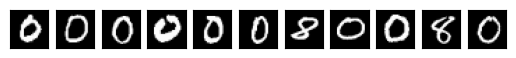

In [14]:
from matplotlib import pyplot as plt

mistake_indices = torch.where(~(predictions == test_y))[0]
print("The labels of the mistaken images are: ", test_y[mistake_indices].tolist())
print("And here are the images...")
for ix, mistake_ind in enumerate(mistake_indices):
    plt.subplot(1, len(mistake_indices), ix + 1)
    plt.imshow(test_x[ix], cmap='gray')
    plt.tick_params(left=False, right=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

## Autograder for k-NN

In [15]:
grader.grade(test_case_id = 'knn_distance_matrix', answer = getsource(knn_distance_matrix))
grader.grade(test_case_id = 'knn_find_k_nearest_neighbors', answer = getsource(knn_find_k_nearest_neighbors))
grader.grade(test_case_id = 'knn_predict', answer = getsource(knn_predict))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
